# 📚 Import Libraries

In [66]:
import folium
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Tuple, Optional, Any, Dict

from IPython.display import display
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import ParameterGrid

# Class Functions

## 🏙️ City Data

A class to handle city data and distance calculations.

In [58]:
class CityData:
    """A class to handle city data and distance calculations."""

    def __init__(self, csv_path: str):
        """Initialize CityData with a CSV file path."""
        self.capital: pd.DataFrame = pd.read_csv(csv_path)
        self.distances: np.ndarray = self._calculate_distances()

    def _haversine(self, lat1: float, lon1: float, lat2: float, lon2: float) -> float:
        """Calculate the distance between two points using the Haversine formula."""
        R: int = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlon: float = lon2 - lon1
        dlat: float = lat2 - lat1
        a: float = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c: float = 2 * atan2(sqrt(a), sqrt(1 - a))
        return R * c

    def _calculate_distances(self) -> np.ndarray:
        """Calculate the distance matrix between all capital cities."""
        n_cities: int = len(self.capital)
        distances: np.ndarray = np.zeros((n_cities, n_cities))
        for i in range(n_cities):
            for j in range(n_cities):
                if i != j:
                    distances[i, j] = self._haversine(
                        self.capital.latitude[i],
                        self.capital.longitude[i],
                        self.capital.latitude[j],
                        self.capital.longitude[j],
                    )
        return distances

    def get_map_center(self) -> List[float]:
        """Get the center coordinates for map display."""
        return [self.capital["latitude"].mean(), self.capital["longitude"].mean()]

    def print_head(self) -> None:
        """Print the head of dataframe"""
        print("First 5 rows of the data:")
        print(self.capital.head())

    def print_info(self) -> None:
        """Print information of data"""
        print(f"Number of capital cities: {len(self.capital)}")

    def get_city_coordinates(self, index: int) -> Tuple[float, float]:
        """Get the latitude and longitude of the city"""
        return self.capital.latitude[index], self.capital.longitude[index]

    def get_city_name(self, index: int) -> str:
        """Get the name of the city"""
        return self.capital.capital[index]
    
    def get_province_name(self, index: int) -> str:
        """Get the name of the province"""
        return self.capital.province[index]

## 🌍 Map Visualizer

A class to handle map visualization.

In [59]:
class MapVisualizer:
    """A class to handle map visualization."""

    def __init__(self, city_data: CityData):
        """Initialize MapVisualizer with city data."""
        self.city_data: CityData = city_data

    def display_initial_map(self) -> None:
        """Display the initial map with capital city markers."""
        map_center: List[float] = self.city_data.get_map_center()
        my_map: folium.Map = folium.Map(location=map_center, zoom_start=4)
        for _, row in self.city_data.capital.iterrows():
            folium.Marker(
                location=[row["latitude"], row["longitude"]],
                popup=f"{row['capital']}, {row['province']}",
            ).add_to(my_map)
        print("Initial map of capital cities:")
        display(my_map)

    def visualize_path(self, path: List[int]) -> None:
        """Visualize the best path on a map."""
        map_center: List[float] = self.city_data.get_map_center()
        my_map: folium.Map = folium.Map(location=map_center, zoom_start=4)
        points: List[tuple[float,float]] = [self.city_data.get_city_coordinates(i) for i in path]
        folium.PolyLine(points, weight=3, color='red').add_to(my_map)
        
        for i, city_index in enumerate(path):
            city_name: str = self.city_data.get_city_name(city_index)
            province_name: str = self.city_data.get_province_name(city_index)
            lat: float
            lon: float
            lat, lon = self.city_data.get_city_coordinates(city_index)
            folium.Marker([lat, lon], popup=f"[{i+1}] {city_name}, {province_name}.").add_to(my_map)
        print("\nVisualizing the best path...")
        display(my_map)

## 🌐 Distance Visualizer

A class to handle distance matrix visualization.

In [62]:
class DistanceVisualizer:
    """A class to handle distance matrix visualization."""

    def __init__(self, distances: np.ndarray, city_data: CityData):
        """Initialize DistanceVisualizer with distance data and city data."""
        self.distances: np.ndarray = distances
        self.city_data: CityData = city_data

    def annotate_km(self, data: np.ndarray, **kws: Any) -> None:
        """Annotate a heatmap with distances in kilometers."""
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                plt.text(
                    j + 0.5,
                    i + 0.5,
                    f"{data[i, j]:.0f} km",
                    ha="center",
                    va="center",
                    color="white",
                )

    def display_distance_matrix(self, start_index: int = 10, end_index: int = 16) -> None:
        """Display a sample of the distance matrix."""
        sample_distances: np.ndarray = self.distances[start_index:end_index, start_index:end_index]
        print("\nSample distance matrix (5x5):")
        print(sample_distances)

    def display_distance_heatmap(self, start_index: int = 10, end_index: int = 16) -> None:
        """Display a heatmap of the distance matrix."""
        sample_distances: np.ndarray = self.distances[start_index:end_index, start_index:end_index]
        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(
            sample_distances,
            cmap="viridis",
            annot=False,
            xticklabels=self.city_data.capital["capital"][start_index:end_index],
            yticklabels=self.city_data.capital["capital"][start_index:end_index],
        )
        self.annotate_km(sample_distances)
        plt.title("Distance Matrix Heatmap")
        plt.xlabel("City")
        plt.ylabel("City")
        plt.show()

## 🐜 Ant Colony Optimizer

A class to implement the Ant Colony Optimization algorithm.

In [64]:
class AntColonyOptimizer:
    """A class to implement the Ant Colony Optimization algorithm."""

    def __init__(
        self,
        distances: np.ndarray,
        n_ants: int,
        n_iterations: int,
        decay_rate: float = 0.5,
        alpha: float = 1,
        beta: float = 5,
        q: int = 1,
    ):
        """Initialize the ACO parameters."""
        self.distances: np.ndarray = distances
        self.n_cities: int = len(distances)
        self.n_ants: int = n_ants
        self.n_iterations: int = n_iterations
        self.decay_rate: float = decay_rate
        self.alpha: float = alpha
        self.beta: float = beta
        self.q: int = q
        self.pheromone: np.ndarray = np.ones((self.n_cities, self.n_cities))
        self.best_path: Optional[List[int]] = None
        self.best_path_length: float = float("inf")

    def _select_next_city(self, current_city: int, visited: np.ndarray) -> int:
        """Select the next city based on pheromone and distance."""
        unvisited: np.ndarray = np.where(visited == False)[0]
        probabilities: List[float] = []
        total_prob: float = 0

        for city in unvisited:
            eta: float = (
                1 / self.distances[current_city][city]
                if self.distances[current_city][city] > 0
                else 0
            )
            tau: float = self.pheromone[current_city][city]
            prob: float = (tau**self.alpha) * (eta**self.beta)
            probabilities.append(prob)
            total_prob += prob

        if total_prob == 0:
            return random.choice(unvisited)
        probabilities = np.array(probabilities) / total_prob
        return np.random.choice(unvisited, p=probabilities)

    def _move_ant(self, start_city: int) -> List[int]:
        """Move an ant and return a path."""
        current_city: int = start_city
        visited: np.ndarray = np.zeros(self.n_cities, dtype=bool)
        visited[current_city] = True
        path: List[int] = [current_city]

        for _ in range(self.n_cities - 1):
            next_city: int = self._select_next_city(current_city, visited)
            path.append(next_city)
            visited[next_city] = True
            current_city = next_city
        path.append(start_city)
        return path

    def _calculate_path_length(self, path: List[int]) -> float:
        """Calculate the total length of a path."""
        length: float = 0
        for i in range(len(path) - 1):
            length += self.distances[path[i]][path[i + 1]]
        return length

    def _update_pheromones(self, paths: List[List[int]]) -> None:
        """Update the pheromone trails based on ant paths."""
        self.pheromone *= 1 - self.decay_rate

        for path in paths:
            path_length: float = self._calculate_path_length(path)
            for i in range(len(path) - 1):
                delta_pheromone: float = self.q / path_length if path_length > 0 else 0
                self.pheromone[path[i]][path[i + 1]] += delta_pheromone

    def optimize(self) -> List[int]:
        """Run the ACO optimization algorithm."""
        for i in range(self.n_iterations):
            paths: List[List[int]] = []
            for _ in range(self.n_ants):
                start_city: int = random.randint(0, self.n_cities - 1)
                paths.append(self._move_ant(start_city))
            self._update_pheromones(paths)
            for path in paths:
                path_length: float = self._calculate_path_length(path)
                if path_length < self.best_path_length:
                    self.best_path = path
                    self.best_path_length = path_length
            if i % 10 == 0:
                print(f"Iteration {i+1}: Best path length = {self.best_path_length}")
        return self.best_path

## 🔧 Hyperparameter Optimizer

A class to handle hyperparameter optimization for ACO.

In [67]:
class HyperparameterOptimizer:
    """A class to handle hyperparameter optimization for ACO."""

    def __init__(self, distances: np.ndarray):
        """Initialize HyperparameterOptimizer with distance data."""
        self.distances: np.ndarray = distances

    def _aco_fitness(self, params: Dict[str, Any]) -> float:
        """Fitness function to evaluate ACO parameters."""
        n_ants: int = params["n_ants"]
        n_iterations: int = params["n_iterations"]
        decay_rate: float = params["decay_rate"]
        alpha: float = params["alpha"]
        beta: float = params["beta"]
        aco: AntColonyOptimizer = AntColonyOptimizer(
            self.distances, n_ants, n_iterations, decay_rate, alpha, beta
        )
        best_path = aco.optimize()
        best_path_length: float = aco._calculate_path_length(best_path)
        return 1 / best_path_length if best_path_length > 0 else 0

    def optimize(self, param_grid: Optional[Dict[str, List[Any]]] = None) -> Dict[str, Any]:
        """Optimize ACO hyperparameters using ParameterGrid."""
        if param_grid is None:
            param_grid: Dict[str, List[Any]] = {
                "n_ants": [20],
                "n_iterations": [100],
                "decay_rate": [0.2],
                "alpha": [1],
                "beta": [3],
            }
        
        best_score: float = 0
        best_params: Optional[Dict[str, Any]] = None
        grid: ParameterGrid = ParameterGrid(param_grid)
        for params in grid:
            score: float = self._aco_fitness(params)
            print(f"Params : {params} | Score : {score}")
            if score > best_score:
                best_score = score
                best_params = params
        print(f"\nBest Hyperparameters: {best_params} with score: {best_score}")
        return best_params

## 🎉 Result Display

A class to handle displaying the final results.

In [68]:
class ResultDisplay:
    """A class to handle displaying the final results."""

    def __init__(self, city_data: CityData, distances: np.ndarray):
        """Initialize ResultDisplay with city data and distances."""
        self.city_data: CityData = city_data
        self.distances: np.ndarray = distances

    def display_result(self, path: List[int]) -> None:
        """Display the sequence of visited cities with distances in a table."""
        data: List[List[str]] = []
        total_distance: float = 0
        
        for i in range(len(path) - 1):
            current_city_index: int = path[i]
            next_city_index: int = path[i+1]
            
            current_city_name: str = self.city_data.get_city_name(current_city_index)
            current_province_name: str = self.city_data.get_province_name(current_city_index)
            
            distance: float = self.distances[current_city_index][next_city_index]
            total_distance += distance

            data.append([f"{i+1:02d}", current_city_name, current_province_name, f"{distance:.2f} km"]) # added string format on number
        
        df: pd.DataFrame = pd.DataFrame(data, columns=["Number", "City Name", "Province Name", "Distance (km)"])
        display(df)
        print(f"\nTotal distance: {total_distance:.2f} km")

# Call Class Functions

## Data Initialization

### 🔢 Number of Capital Cities

In [69]:
city_data = CityData("data/capital.csv")
city_data.print_info()

Number of capital cities: 38


### 🌟 First 5 rows of The Data

In [70]:
city_data.print_head()

First 5 rows of the data:
         province     capital  latitude  longitude
0            Aceh  Banda Aceh      5.55      95.32
1  Sumatera Utara       Medan      3.58      98.67
2  Sumatera Barat      Padang     -0.94     100.36
3            Riau   Pekanbaru      0.54     101.44
4           Jambi       Jambi     -1.60     103.61


## Map and Distance Visualization

### 🌍 Map Visualizer

In [71]:
map_visualizer = MapVisualizer(city_data)
map_visualizer.display_initial_map()

Initial map of capital cities:


### 🌐 Distance Visualization

In [72]:
distance_visualizer = DistanceVisualizer(city_data.distances, city_data)
distance_visualizer.display_distance_matrix(start_index=10, end_index=16)


Sample distance matrix (5x5):
[[  0.         116.86387579 407.23588814 430.28878745 665.16257259
   74.60268441]
 [116.86387579   0.         311.39222252 321.10258909 569.5398012
  182.69488794]
 [407.23588814 311.39222252   0.          90.23648427 258.70628214
  481.51029586]
 [430.28878745 321.10258909  90.23648427   0.         269.39700626
  501.83141917]
 [665.16257259 569.5398012  258.70628214 269.39700626   0.
  739.63019814]
 [ 74.60268441 182.69488794 481.51029586 501.83141917 739.63019814
    0.        ]]


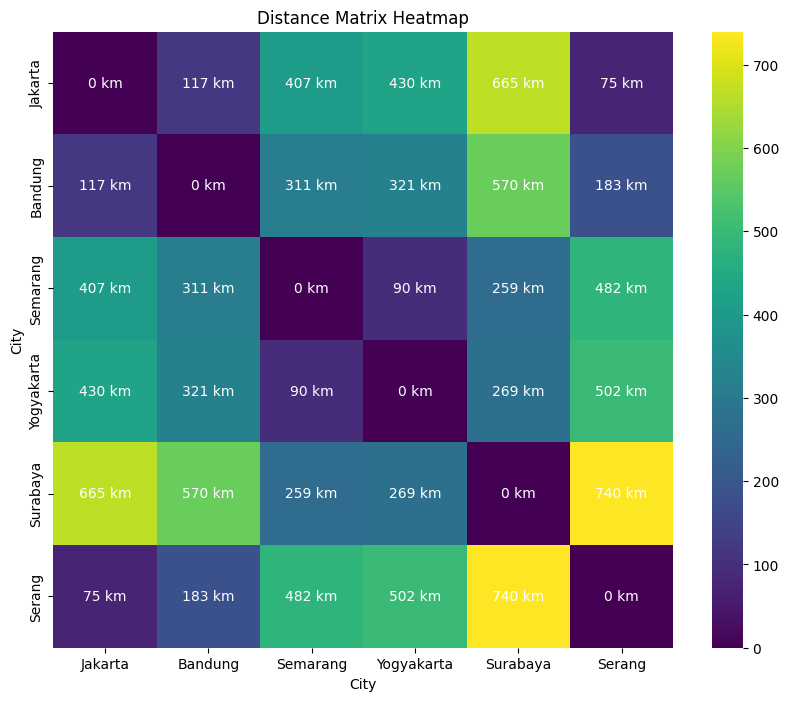

In [73]:
distance_visualizer.display_distance_heatmap(start_index=10, end_index=16)

## Hyperparameter Optimization and Best Params

### 🔧 Hyperparameter Optimizers

In [74]:
custom_param_grid = {
    'n_ants': [20, 40, 60], # Number of ants
    'n_iterations': [100, 150, 200], # Number of iterations
    'decay_rate': [0.2, 0.5, 0.8], # Pheromone decay rate
    'alpha': [1, 2], # Alpha parameter
    'beta': [3, 5] # Beta parameter
}

In [75]:
print("Starting hyperparameter optimization...")
hyperparameter_optimizer = HyperparameterOptimizer(city_data.distances)
best_params = hyperparameter_optimizer.optimize(custom_param_grid)

Starting hyperparameter optimization...
Iteration 1: Best path length = 19747.38354890969
Iteration 11: Best path length = 19045.455393592736
Iteration 21: Best path length = 19045.455393592736
Iteration 31: Best path length = 16738.135013973944
Iteration 41: Best path length = 16550.093376791476
Iteration 51: Best path length = 16277.243817113404
Iteration 61: Best path length = 15301.787343028564
Iteration 71: Best path length = 14982.44280753167
Iteration 81: Best path length = 14982.44280753167
Iteration 91: Best path length = 14982.44280753167
Params : {'alpha': 1, 'beta': 3, 'decay_rate': 0.2, 'n_ants': 20, 'n_iterations': 100} | Score : 6.674479007504038e-05
Iteration 1: Best path length = 20679.608977962653
Iteration 11: Best path length = 16782.703227675996
Iteration 21: Best path length = 16782.703227675996
Iteration 31: Best path length = 16782.703227675996
Iteration 41: Best path length = 16646.768192270527
Iteration 51: Best path length = 15842.404716665722
Iteration 61: B

### 🏆 Best Params

ACO with optimized hyperparameters

In [80]:
print("\nRunning ACO with optimized hyperparameters...")
aco = AntColonyOptimizer(
    city_data.distances,
    n_ants=best_params["n_ants"],
    n_iterations=best_params["n_iterations"],
    decay_rate=best_params["decay_rate"],
    alpha=best_params["alpha"],
    beta=best_params["beta"],
)
best_path = aco.optimize()


Running ACO with optimized hyperparameters...
Iteration 1: Best path length = 21199.051303693013
Iteration 11: Best path length = 19717.0155736466
Iteration 21: Best path length = 17842.216145243736
Iteration 31: Best path length = 17549.685864541185
Iteration 41: Best path length = 16669.801356476084
Iteration 51: Best path length = 16220.450067751251
Iteration 61: Best path length = 15080.824993719109
Iteration 71: Best path length = 15080.824993719109
Iteration 81: Best path length = 15080.824993719109
Iteration 91: Best path length = 15080.824993719109
Iteration 101: Best path length = 15080.824993719109
Iteration 111: Best path length = 15080.824993719109
Iteration 121: Best path length = 15080.824993719109
Iteration 131: Best path length = 15080.824993719109
Iteration 141: Best path length = 15080.824993719109
Iteration 151: Best path length = 15080.824993719105
Iteration 161: Best path length = 15080.824993719105
Iteration 171: Best path length = 15080.824993719105
Iteration 18

## Final Result Display

### 🗺️ Best Path Route Map

In [78]:
map_visualizer.visualize_path(best_path)


Visualizing the best path...


### 👣 Sequence of Visited Capital Cities

In [79]:
result_display = ResultDisplay(city_data, city_data.distances)
result_display.display_result(best_path)

,Number,City Name,Province Name,Distance (km)
0,01,Palu,Sulawesi Tengah,226.89 km
1,02,Mamuju,Sulawesi Barat,280.87 km
2,03,Makassar,Sulawesi Selatan,368.85 km
3,04,Kendari,Sulawesi Tenggara,502.60 km
4,05,Gorontalo,Gorontalo,225.30 km
5,06,Manado,Sulawesi Utara,357.83 km
6,07,Sofifi,Maluku Utara,406.84 km
7,08,Sorong,Papua Barat Daya,313.32 km
8,09,Manokwari,Papua Barat,320.59 km
9,10,Nabire,Papua Tengah,394.79 km



Total distance: 15035.77 km
